In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from utils import *
import scipy.stats
import seaborn as sns
from ipywidgets import interact, interactive, FloatProgress, IntProgress

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
fx_1minute_bar_catalog()

defaultdict(list,
            {'EURGBP': ['2015', '2014', '2013', '2016', '2012'],
             'EURJPY': ['2012', '2015', '2013', '2016', '2014'],
             'EURUSD': ['2012', '201612', '2013', '2014', '2016', '2015'],
             'GBPCHF': ['2015', '2014', '2016'],
             'GBPJPY': ['2016', '2013', '2015', '2014', '2012'],
             'GBPUSD': ['2013', '2015', '2012', '2014', '2016'],
             'USDJPY': ['2013', '2016', '2014', '2015', '2012'],
             'XAGUSD': ['2013', '2015', '2016', '2012', '2014'],
             'XAUGBP': ['2012', '2016', '2015', '2014', '2013'],
             'XAUUSD': ['2012', '2015', '2014', '2013', '2016']})

In [3]:
RETURN_PERIOD = 1
ANN_FACTOR_1MINUTE_BARS = np.sqrt(252 * 24 * 60 / RETURN_PERIOD)
TS_SECS = 60 # number of seconds in a regular timestep. 60 for 1x 1-minute bar
def load_data(syms, date):
    
    data = {}
    for sym in syms:
        ds = load_1minute_fx_bars(sym, date)['close']
        # annualised log returns
        lret = logreturn(ds, ds.shift(RETURN_PERIOD))* ANN_FACTOR_1MINUTE_BARS
        lret.name=sym
        data[sym] = lret
        
    df= pd.DataFrame(data)
    df = df.fillna(0)
    # put add timestamp into dataframe, and compute time since last sample
    df['ts'] = df.index
    df['time_step'] = ((df['ts']- df['ts'].shift(RETURN_PERIOD)) * 1e-9).astype(int)
    
    return df

In [19]:
syms=['EURUSD', 'GBPUSD', 'EURGBP']
date = 2014

In [20]:
df = load_data(syms, date)

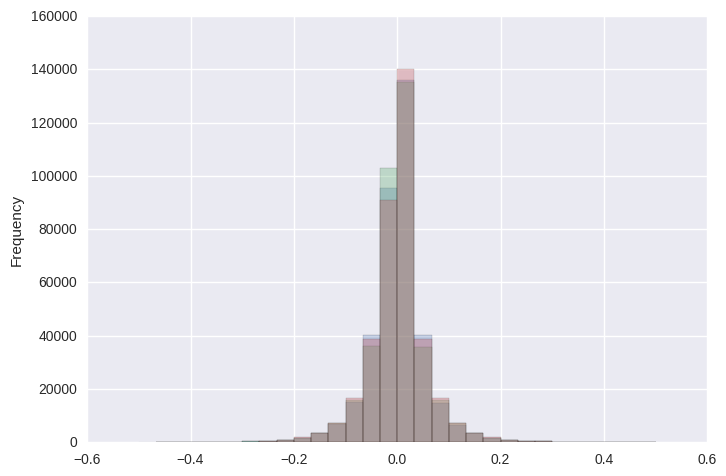

In [21]:
df['EURUSD'].plot.hist(bins=30, range=(-.5,.5),alpha=0.3)
df['GBPUSD'].plot.hist(bins=30, range=(-.5,.5),alpha=0.3)
df['EURGBP'].plot.hist(bins=30, range=(-.5,.5),alpha=0.3)

In [22]:
print df.head(5)

                       EURGBP    EURUSD    GBPUSD                  ts  \
ts                                                                      
2014-01-01 17:00:00  0.000000  0.000000  0.000000 2014-01-01 17:00:00   
2014-01-01 17:01:00  0.000000 -0.074436 -0.003636 2014-01-01 17:01:00   
2014-01-01 17:02:00  0.036290 -0.144520  0.014546 2014-01-01 17:02:00   
2014-01-01 17:03:00 -0.036290  0.078833  0.083632 2014-01-01 17:03:00   
2014-01-01 17:04:00  0.014516 -0.017518 -0.010908 2014-01-01 17:04:00   

                               time_step  
ts                                        
2014-01-01 17:00:00 -9223372036854775808  
2014-01-01 17:01:00                   60  
2014-01-01 17:02:00                   60  
2014-01-01 17:03:00                   60  
2014-01-01 17:04:00                   60  


In [23]:
# 1 hour lookback
sequence_length = 30

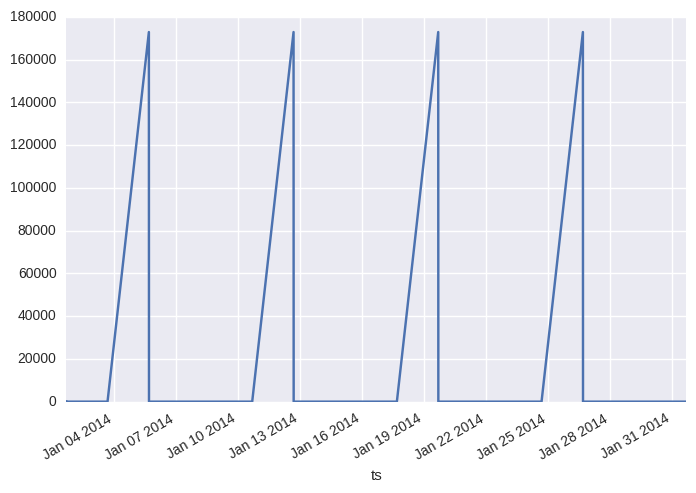

In [25]:
df['time_step']['2014-01'][1:].plot()

In [26]:
# average run length
max_samples = len(df) - sequence_length
progress = IntProgress(min=0, max=max_samples)
display(progress)
i = 0
rl = 0
results = []
while i < max_samples:
    if df['time_step'][i] == TS_SECS:
        rl += 1
    else:
        results.append(rl)
        while df['time_step'][i] != TS_SECS:
            i+=1
        rl = 0
    i +=1
    if i%1000 == 0:
        progress.value = i

run_length = pd.Series(results)

count     166.000000
mean     2217.198795
std      2466.881192
min         0.000000
25%       155.750000
50%      1317.000000
75%      3276.250000
max      7198.000000
dtype: float64

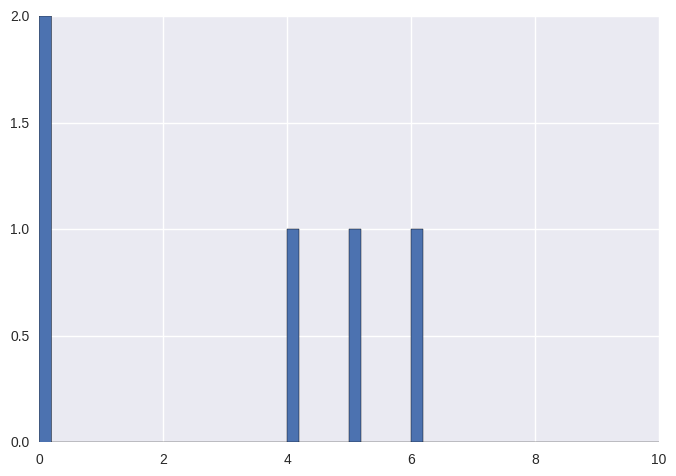

In [27]:
display(run_length.describe())
run_length.hist(bins=50,range=(0,10))


In [28]:
sequence_length

30

In [29]:
%%time

# construct samples
max_samples = len(df) - sequence_length
#max_samples = 50000

nsyms = len(syms)

progress = IntProgress(min=0, max=max_samples)
display(progress)

sequences = np.zeros((max_samples, sequence_length, nsyms))
seq_idx = 0                     

i = 0
while not (df['time_step'][i:i+sequence_length] == TS_SECS).all():
    i += 1
print "skipped",i
while i < max_samples:   
    steps = df['time_step'][i:i+sequence_length]    
    # only include sequences where all samples have the same step size
    if (steps == TS_SECS).all():
        seq = df[syms][i: i + sequence_length]
        sequences[seq_idx] = seq
        seq_idx +=1

    i += 1
    if i%1000 == 0:
        progress.value = i

print seq_idx, sequences.shape
sequences = sequences[:seq_idx,:,:]
print sequences.shape

skipped 32
366488 (371235, 30, 3)
(366488, 30, 3)
CPU times: user 12min 8s, sys: 1.17 s, total: 12min 9s
Wall time: 12min 8s


In [34]:
fname = "sequences_{l}_{s}_{d}.h5".format(s="_".join(syms), d=date, l=sequence_length)
print fname

sequences_30_EURUSD_GBPUSD_EURGBP_2014.h5


In [35]:
import h5py
with h5py.File(fname, 'w') as f:
    f['sequences'] = sequences

In [36]:
with h5py.File(fname, 'r') as f:
    sequences = f['sequences'][...]

In [37]:
sequences.shape

(366488, 30, 3)

In [61]:
import datetime as dt
ts = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
print ts


20170125-215922



# tests 
Target = 
- sum of sequence. can it learn to add them up..???
- mean of first half of sequence
- mean of first half of sequence minus mean of second half of sequence
( can do this on random data..)